<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Assignment2/Assignment2_Project2_hate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.9MB/s 
     |████████████████████████████████| 901kB 36.4MB/s 
     |████████████████████████████████| 3.3MB 34.1MB/s 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import requests
import re
import string
import math
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Load the data

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# Experiment focus on hate, irony and offensive
# Both 3 tasks can be run on the same code by alternating the "task" parameter below
# Other tasks have not been tested and may occur errors
task='hate'
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt", allow_redirects=True)
open('test_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt", allow_redirects=True)
open('test_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_labels.txt", allow_redirects=True)
open('train_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_text.txt", allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_labels.txt", allow_redirects=True)
open('val_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_text.txt", allow_redirects=True)
open('val_text.txt', 'wb').write(r.content)

file = open('test_labels.txt')
test_labels = file.readlines()
file.close
file = open('test_text.txt')
test_text = file.readlines()
file.close
file = open('train_labels.txt')
train_labels = file.readlines()
file.close
file = open('train_text.txt')
train_text = file.readlines()
file.close
file = open('val_labels.txt')
val_labels = file.readlines()
file.close
file = open('val_text.txt')
val_text = file.readlines()
file.close

print("Number of total data:        ", len(train_labels)+len(val_labels)+len(test_labels))
print("Number of train labels:      ", len(train_labels))
print("Number of train text:        ", len(train_text))
print("Number of validation labels: ", len(val_labels))
print("Number of validation text:   ", len(val_text))
print("Number of test labels:       ", len(test_labels))
print("Number of test text:         ", len(test_text))

Number of total data:         12970
Number of train labels:       9000
Number of train text:         9000
Number of validation labels:  1000
Number of validation text:    1000
Number of test labels:        2970
Number of test text:          2970


In [ ]:
# Create subset from the dataset for system development
#test_labels = val_labels[:]
#test_text = val_text[:]
#train_labels = train_labels[500:2500]
#train_text = train_text[500:2500]
#val_labels = val_labels[:100]
#val_text = val_text[:100]

In [ ]:
# Download label mapping
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
class_labels = [row[1] for row in csvreader if len(row) > 1]
print('Labels:', class_labels)

Labels: ['not-hate', 'hate']


In [ ]:
df = pd.DataFrame(data={'label': train_labels + val_labels + test_labels, 'text': train_text + val_text + test_text})
df

,label,text
0,0\n,@user nice new signage. Are you not concerned ...
1,1\n,A woman who you fucked multiple times saying y...
2,1\n,@user @user real talk do you have eyes or were...
3,1\n,your girlfriend lookin at me like a groupie in...
4,0\n,Hysterical woman like @user \n
...,...,...
12965,0\n,@user Calling them #IllegalAliens is heartless...
12966,0\n,Silly Killary WANNABE !! And @user numbers JUS...
12967,0\n,@user @user @user @user @user @user @user @use...
12968,1\n,@user StopImmigration \n


In [ ]:
df['length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df

,label,text,length
0,0\n,@user nice new signage. Are you not concerned ...,18
1,1\n,A woman who you fucked multiple times saying y...,21
2,1\n,@user @user real talk do you have eyes or were...,19
3,1\n,your girlfriend lookin at me like a groupie in...,12
4,0\n,Hysterical woman like @user \n,5
...,...,...,...
12965,0\n,@user Calling them #IllegalAliens is heartless...,19
12966,0\n,Silly Killary WANNABE !! And @user numbers JUS...,22
12967,0\n,@user @user @user @user @user @user @user @use...,73
12968,1\n,@user StopImmigration \n,3


In [ ]:
np.mean(df['length'][:len(train_text)].tolist())

25.081777777777777

  label  counts
0   0\n    7508
1   1\n    5462


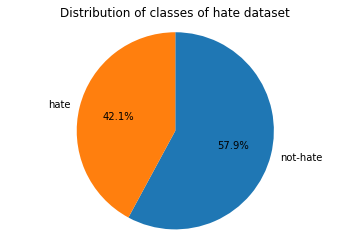

In [ ]:
# Show distribution of classes
df_class = df.groupby('label').size().reset_index(name='counts')
print(df_class)

labels = class_labels
sizes = df_class['counts'].tolist()
plt.title(f"Distribution of classes of {task} dataset")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

# Pre-processing

In [ ]:
# Cleaning the data
df['label'] = df['label'].apply(lambda x: re.sub('\n','', x))
df['text'] = df['text'].apply(lambda x: re.sub('\n','', x))
# Lowercase the words
df['cleaned'] = df['text'].apply(lambda x: x.lower())
# Remove digits and words containing digits
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Remove Punctuations
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Remove extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Remove stop words
stop_words = set(nltk.corpus.stopwords.words("english"))
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stop words removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# Remove stop words again
df['lemmatized'] = df['lemmatized'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

df

CPU times: user 37min 18s, sys: 16.5 s, total: 37min 35s
Wall time: 37min 41s


# Experiment

In [ ]:
df['lemmatized'] = df['lemmatized'].astype(str)
train_text_list = df['lemmatized'][:len(train_text)].tolist()
val_text_list = df['lemmatized'][len(train_text):len(train_text) + len(val_text)].tolist()
test_text_list = df['lemmatized'][len(train_text) + len(val_text):].tolist()

df['label'] = df['label'].astype(int)
train_label_list = df['label'][:len(train_text)].tolist()
val_label_list = df['label'][len(train_text):len(train_text) + len(val_text)].tolist()
test_label_list = df['label'][len(train_text) + len(val_text):].tolist()

In [ ]:
%%time
# Creating feature vector
# Most frequently 3000 word is selected as the features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=3000)

# Only training set will be used to obtain features
train_set_vector = vectorizer.fit_transform(train_text_list)
val_set_vector = vectorizer.transform(val_text_list)
test_set_vector = vectorizer.transform(test_text_list)

train_set_label = [label for label in train_label_list]
val_set_label = [label for label in val_label_list]
test_set_label = [label for label in test_label_list]

CPU times: user 203 ms, sys: 7.01 ms, total: 210 ms
Wall time: 219 ms


In [ ]:
%%time
# Creating feature tensor
# Most frequently 3000 word is selected as the features
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_features = 3000
maxlen = 30
tokenizer = Tokenizer(num_words=3000)

# Only training set will be used to obtain features
tokenizer.fit_on_texts(train_text_list)

train_set_content = tokenizer.texts_to_sequences(train_text_list)
train_set_content = sequence.pad_sequences(train_set_content, maxlen=maxlen)
val_set_content = tokenizer.texts_to_sequences(val_text_list)
val_set_content = sequence.pad_sequences(val_set_content, maxlen=maxlen)
test_set_content = tokenizer.texts_to_sequences(test_text_list)
test_set_content = sequence.pad_sequences(test_set_content, maxlen=maxlen)

CPU times: user 434 ms, sys: 11.1 ms, total: 445 ms
Wall time: 484 ms


In [ ]:
import seaborn as sn
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier

# Conventional

In [ ]:
%%time
# Dummy (majority) is used as the classification model
Dummyclf = DummyClassifier(strategy='most_frequent')
# Train Dummy Classifier
Dummyclf = Dummyclf.fit(train_set_vector, train_set_label)

CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 3.47 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = Dummyclf.predict(test_set_vector)

CPU times: user 194 µs, sys: 1e+03 ns, total: 195 µs
Wall time: 203 µs


Majority:
Accuracy Score: 0.5784511784511784
Macro F1 Score: 0.36646757679180886
Clasification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73      1718
           1       0.00      0.00      0.00      1252

    accuracy                           0.58      2970
   macro avg       0.29      0.50      0.37      2970
weighted avg       0.33      0.58      0.42      2970



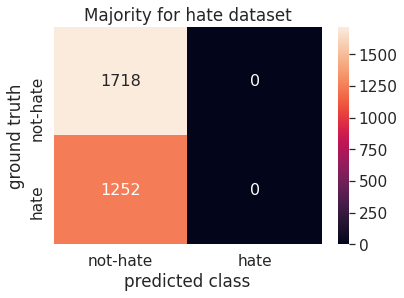

In [ ]:
print("Majority:")
#print('Best parameters: ', Dummyclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label, zero_division=0))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Majority for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Naive Bayes Classifier is used as the classification model
NBclf = MultinomialNB(alpha=1.0, fit_prior=True)
param_grid = {
    # 'fit_prior' : [True, False],
}
NBclf = GridSearchCV(estimator=NBclf, param_grid=param_grid, n_jobs=-1)
# Train Naive Bayes Classifier
NBclf = NBclf.fit(train_set_vector, train_set_label)

CPU times: user 205 ms, sys: 63 ms, total: 268 ms
Wall time: 1.19 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = NBclf.predict(test_set_vector)

CPU times: user 996 µs, sys: 1.01 ms, total: 2.01 ms
Wall time: 1.45 ms


Naive Bayes:
Best parameters:  {}
Accuracy Score: 0.47474747474747475
Macro F1 Score: 0.4148817943018792
Clasification report:
               precision    recall  f1-score   support

           0       0.76      0.13      0.23      1718
           1       0.44      0.94      0.60      1252

    accuracy                           0.47      2970
   macro avg       0.60      0.54      0.41      2970
weighted avg       0.63      0.47      0.39      2970



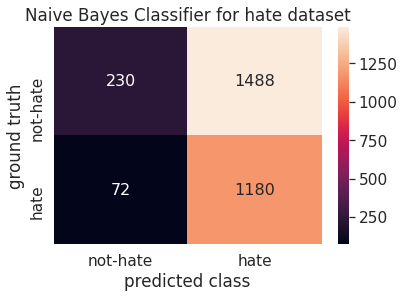

In [ ]:
print("Naive Bayes:")
print('Best parameters: ', NBclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Naive Bayes Classifier for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Decision Tree is used as the classification model
DTclf = DecisionTreeClassifier(criterion="entropy", min_samples_split=10)
param_grid = {
    # 'criterion' : ["entropy", "gini"],
    # 'max_depth' : np.arange(10, 21, 1),
    # 'min_samples_split' : np.arange(10, 21, 1),
}
DTclf = GridSearchCV(estimator=DTclf, param_grid=param_grid, n_jobs=-1)
# Train Decision Tree Classifier
DTclf = DTclf.fit(train_set_vector, train_set_label)

CPU times: user 914 ms, sys: 3.98 ms, total: 918 ms
Wall time: 3.11 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = DTclf.predict(test_set_vector)

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.98 ms


Decision Tree:
Best parameters:  {}
Accuracy Score: 0.4872053872053872
Macro F1 Score: 0.4594496085132226
Clasification report:
               precision    recall  f1-score   support

           0       0.67      0.23      0.34      1718
           1       0.44      0.85      0.58      1252

    accuracy                           0.49      2970
   macro avg       0.56      0.54      0.46      2970
weighted avg       0.57      0.49      0.44      2970



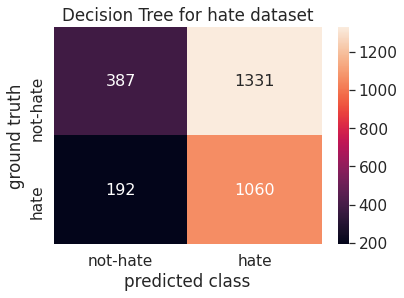

In [ ]:
print("Decision Tree:")
print('Best parameters: ', DTclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Decision Tree for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# K-Nearest Neighbors is used as the classification model
KNNclf = KNeighborsClassifier(weights="distance", p = 2, n_neighbors=5) #euclidean distance
param_grid = {
        #'n_neighbors': np.arange(1, 11, 1),
        #'weights': ["uniform", "distance"],
}
KNNclf = GridSearchCV(estimator=KNNclf, param_grid=param_grid, n_jobs=-1)
# Train K-Nearest Neighbors Classifier
KNNclf = KNNclf.fit(train_set_vector, train_set_label)

CPU times: user 193 ms, sys: 2 ms, total: 195 ms
Wall time: 1.59 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = KNNclf.predict(test_set_vector)

CPU times: user 675 ms, sys: 218 ms, total: 893 ms
Wall time: 897 ms


K-Nearest Neighbors:
Best parameters:  {}
Accuracy Score: 0.5713804713804714
Macro F1 Score: 0.5698871764535239
Clasification report:
               precision    recall  f1-score   support

           0       0.66      0.54      0.60      1718
           1       0.49      0.61      0.54      1252

    accuracy                           0.57      2970
   macro avg       0.57      0.58      0.57      2970
weighted avg       0.59      0.57      0.57      2970



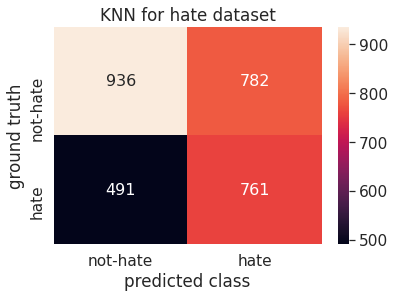

In [ ]:
print("K-Nearest Neighbors:")
print('Best parameters: ', KNNclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"KNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Support Vector Machine is used as the classification model
SVMclf = SVC(kernel='rbf', C=1, gamma=0.1)
param_grid = {
    #'kernel': ["linear", "poly", "rbf"],
    #'C' : np.logspace(-1, 3, 5),
    #'gamma' : np.logspace(-4, -0, 5),
}
SVMclf = GridSearchCV(estimator=SVMclf, param_grid=param_grid, n_jobs=-1)
# Train Support Vector Machine Classifier
SVMclf = SVMclf.fit(train_set_vector, train_set_label)

CPU times: user 9.01 s, sys: 62.9 ms, total: 9.07 s
Wall time: 34.8 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = SVMclf.predict(test_set_vector)

CPU times: user 2.25 s, sys: 5.02 ms, total: 2.25 s
Wall time: 2.26 s


Support Vector Machine:
Best parameters:  {}
Accuracy Score: 0.4808080808080808
Macro F1 Score: 0.44524284480114584
Clasification report:
               precision    recall  f1-score   support

           0       0.68      0.20      0.30      1718
           1       0.44      0.87      0.59      1252

    accuracy                           0.48      2970
   macro avg       0.56      0.53      0.45      2970
weighted avg       0.58      0.48      0.42      2970



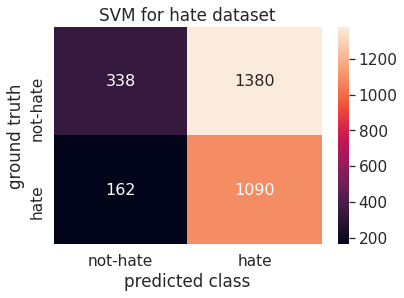

In [ ]:
print("Support Vector Machine:")
print('Best parameters: ', SVMclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SVM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

# Deep Learning

In [ ]:
%%time
# SimpleANN is used as the classification model
model = models.Sequential()
model.add(Dense(32, input_shape=(30,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleANN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 1s 6ms/step - loss: 129.1809 - acc: 0.5045 - val_loss: 6.8521 - val_acc: 0.4930
Epoch 2/5
71/71 [==============================] - 0s 3ms/step - loss: 8.3057 - acc: 0.5304 - val_loss: 14.5254 - val_acc: 0.4340
Epoch 3/5
71/71 [==============================] - 0s 3ms/step - loss: 7.9154 - acc: 0.5219 - val_loss: 6.7683 - val_acc: 0.4290
Epoch 4/5
71/71 [==============================] - 0s 3ms/step - loss: 7.6784 - acc: 0.5064 - val_loss: 19.7559 - val_acc: 0.5

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 163 ms, sys: 10.1 ms, total: 173 ms
Wall time: 163 ms


SimpleANN:
Accuracy Score: 0.5750841750841751
Macro F1 Score: 0.3793109615419009
Clasification report:
               precision    recall  f1-score   support

           0       0.58      0.98      0.73      1718
           1       0.40      0.02      0.03      1252

    accuracy                           0.58      2970
   macro avg       0.49      0.50      0.38      2970
weighted avg       0.50      0.58      0.43      2970



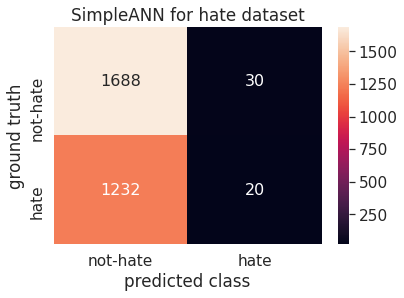

In [ ]:
print("SimpleANN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleANN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# SimpleRNN is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleRNN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          96000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 98,113
Trainable params: 98,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 2s 16ms/step - loss: 0.6632 - acc: 0.6044 - val_loss: 0.6395 - val_acc: 0.6330
Epoch 2/5
71/71 [==============================] - 1s 12ms/step - loss: 0.5100 - acc: 0.7688 - val_loss: 0.5651 - val_

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 405 ms, sys: 23.2 ms, total: 428 ms
Wall time: 327 ms


SimpleRNN:
Accuracy Score: 0.5363636363636364
Macro F1 Score: 0.526484107243154
Clasification report:
               precision    recall  f1-score   support

           0       0.71      0.34      0.46      1718
           1       0.47      0.81      0.59      1252

    accuracy                           0.54      2970
   macro avg       0.59      0.57      0.53      2970
weighted avg       0.61      0.54      0.52      2970



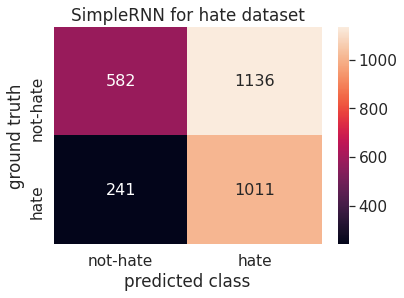

In [ ]:
print("SimpleRNN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleRNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 4s 31ms/step - loss: 0.6642 - acc: 0.5908 - val_loss: 0.5928 - val_acc: 0.6990
Epoch 2/5
71/71 [==============================] - 2s 23ms/step - loss: 0.5061 - acc: 0.7719 - val_loss: 0.5547 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 880 ms, sys: 25.2 ms, total: 905 ms
Wall time: 687 ms


LSTM:
Accuracy Score: 0.4858585858585859
Macro F1 Score: 0.4352598984456787
Clasification report:
               precision    recall  f1-score   support

           0       0.76      0.16      0.27      1718
           1       0.45      0.93      0.60      1252

    accuracy                           0.49      2970
   macro avg       0.61      0.55      0.44      2970
weighted avg       0.63      0.49      0.41      2970



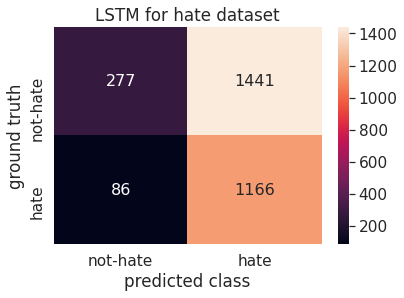

In [ ]:
print("LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 7s 50ms/step - loss: 0.6639 - acc: 0.5969 - val_loss: 0.6308 - val_acc: 0.6310
Epoch 2/5
71/71 [==============================] - 3s 36ms/step - loss: 0.4998 - acc: 0.7683 - val_loss: 0.5685 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.8 s, sys: 39.1 ms, total: 1.84 s
Wall time: 1.5 s


BiLSTM:
Accuracy Score: 0.5063973063973064
Macro F1 Score: 0.47391429167971605
Clasification report:
               precision    recall  f1-score   support

           0       0.75      0.22      0.34      1718
           1       0.46      0.90      0.60      1252

    accuracy                           0.51      2970
   macro avg       0.60      0.56      0.47      2970
weighted avg       0.62      0.51      0.45      2970



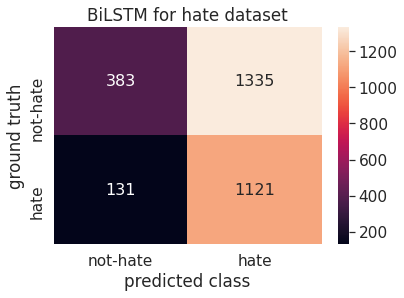

In [ ]:
print("BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 120,993
Trainable params: 120,993
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 2.77 s, sys: 75.5 ms, total: 2.85 s
Wall time: 2.24 s


Hierarchical LSTM:
Accuracy Score: 0.4717171717171717
Macro F1 Score: 0.40731900795921483
Clasification report:
               precision    recall  f1-score   support

           0       0.77      0.12      0.21      1718
           1       0.44      0.95      0.60      1252

    accuracy                           0.47      2970
   macro avg       0.61      0.54      0.41      2970
weighted avg       0.63      0.47      0.38      2970



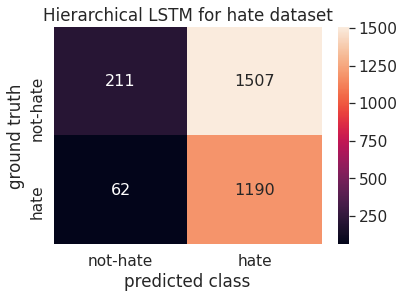

In [ ]:
print("Hierarchical LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 162,369
Trainable params: 162,369
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 4.2 s, sys: 79.8 ms, total: 4.28 s
Wall time: 3.23 s


Hierarchical BiLSTM:
Accuracy Score: 0.5070707070707071
Macro F1 Score: 0.4773713657664831
Clasification report:
               precision    recall  f1-score   support

           0       0.73      0.23      0.35      1718
           1       0.46      0.88      0.60      1252

    accuracy                           0.51      2970
   macro avg       0.59      0.56      0.48      2970
weighted avg       0.62      0.51      0.46      2970



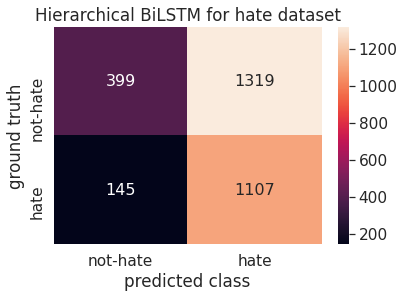

In [ ]:
print("Hierarchical BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiGRU is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(GRU(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiGRU Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
71/71 [==============================] - 8s 48ms/step - loss: 0.6662 - acc: 0.5911 - val_loss: 0.5972 - val_acc: 0.6920
Epoch 2/5
71/71 [==============================] - 3s 36ms/step - loss: 0.4926 - acc: 0.7796 - val_loss: 0.5942 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.33 s, sys: 24.6 ms, total: 1.36 s
Wall time: 1.05 s


BiGRU:
Accuracy Score: 0.4744107744107744
Macro F1 Score: 0.41323357826178464
Clasification report:
               precision    recall  f1-score   support

           0       0.77      0.13      0.22      1718
           1       0.44      0.95      0.60      1252

    accuracy                           0.47      2970
   macro avg       0.61      0.54      0.41      2970
weighted avg       0.63      0.47      0.38      2970



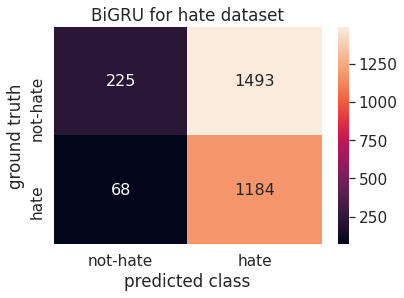

In [ ]:
print("BiGRU:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiGRU for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
%%time
# RoBERTa is used as the classification model
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

#golden_label = [i[1] for i in test_set]
tested_label = []
for i in range(len(test_text)):
  text = test_text[i]
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  tested_label.append(np.argmax(scores))


CPU times: user 9min 40s, sys: 6 s, total: 9min 46s
Wall time: 9min 51s


RoBERTa:
Accuracy Score: 0.5740740740740741
Macro F1 Score: 0.5522990988307143
Clasification report:
               precision    recall  f1-score   support

           0       0.88      0.31      0.45      1718
           1       0.50      0.94      0.65      1252

    accuracy                           0.57      2970
   macro avg       0.69      0.62      0.55      2970
weighted avg       0.72      0.57      0.54      2970



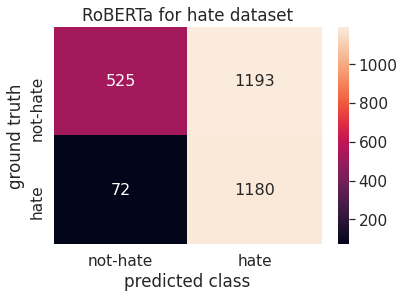

In [ ]:
print("RoBERTa:")
accuracy = metrics.accuracy_score(test_set_label, tested_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, tested_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, tested_label))

cm = confusion_matrix(test_set_label, tested_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"RoBERTa for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()